In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [76]:
df = pd.read_csv('../data/ozone.csv')
display(df.head(),df.shape)

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


(153, 6)

In [77]:
# 결측치 확인
df.isnull().sum()

Ozone      37
Solar.R     7
Wind        0
Temp        0
Month       0
Day         0
dtype: int64

In [78]:
# Solar.R 결측치 처리
df['Solar.R'].fillna(value=df['Solar.R'].median(), inplace=True)

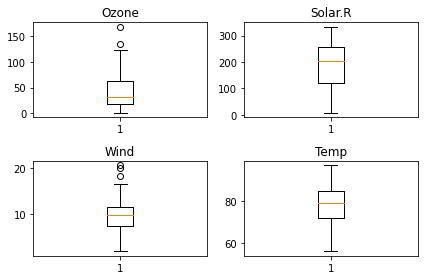

In [79]:
# 이상치 확인
fig = plt.figure()
fig_1 = fig.add_subplot(2,2,1)
fig_2 = fig.add_subplot(2,2,2)
fig_3 = fig.add_subplot(2,2,3)
fig_4 = fig.add_subplot(2,2,4)

fig_1.set_title('Ozone')
fig_1.boxplot(df.loc[~df['Ozone'].isnull(),'Ozone'])

fig_2.set_title('Solar.R')
fig_2.boxplot(df['Solar.R'])

fig_3.set_title('Wind')
fig_3.boxplot(df['Wind'])

fig_4.set_title('Temp')
fig_4.boxplot(df['Temp'])

plt.tight_layout()
plt.show()
# Ozone 결측치 제외하고 표시(?)

In [80]:
# 독립변수 이상치 mean으로 처리
zscore = 1.8
df.loc[np.abs(stats.zscore(df['Solar.R'])) > zscore, 'Solar.R'] = df['Solar.R'].mean()
df.loc[np.abs(stats.zscore(df['Wind'])) > zscore, 'Wind'] = df['Wind'].mean()
df.loc[np.abs(stats.zscore(df['Temp'])) > zscore, 'Temp'] = df['Temp'].mean()

In [81]:
# 종속변수 이상치 mean으로 처리 (결측치 제외)
bool_list = ~df['Ozone'].isnull()
df.loc[bool_list,'Ozone'][np.abs(stats.zscore(df.loc[bool_list,'Ozone'])) > zscore] = df['Ozone'].mean()

In [85]:
# 결측치 분리
df_notnull = df.loc[bool_list,['Ozone', 'Solar.R', 'Wind', 'Temp']]

In [86]:
# 정규화
scaler_x = MinMaxScaler()
scaler_x.fit(df_notnull[['Solar.R', 'Wind', 'Temp']])
x_data_norm = scaler_x.transform(df_notnull[['Solar.R', 'Wind', 'Temp']])

scaler_y = MinMaxScaler()
scaler_y.fit(df_notnull[['Ozone']])
t_data_norm = scaler_y.transform(df_notnull[['Ozone']])

In [87]:
# KNeighborsClassifier
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(x_data_norm, t_data_norm)

KNeighborsRegressor(n_neighbors=3)

In [88]:
# 종속변수 결측치 보간
x_data_test = df.loc[~bool_list, ['Solar.R', 'Wind', 'Temp']]
x_data_test_norm = scaler_x.transform(x_data_test)

t_pred = knn.predict(x_data_test_norm)

df.loc[~bool_list , 'Ozone'] = scaler_y.inverse_transform(t_pred)

In [90]:
df.isnull().sum()
display(df)

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.000000,190.0,7.4,67.000000,5,1
1,36.000000,118.0,8.0,72.000000,5,2
2,12.000000,149.0,12.6,74.000000,5,3
3,18.000000,313.0,11.5,62.000000,5,4
4,14.666667,205.0,14.3,77.882353,5,5
...,...,...,...,...,...,...
148,30.000000,193.0,6.9,70.000000,9,26
149,15.000000,145.0,13.2,77.000000,9,27
150,14.000000,191.0,14.3,75.000000,9,28
151,18.000000,131.0,8.0,76.000000,9,29


In [92]:
# 강사님 코드
# Ozone data를 이용한 Tensorflow 2.X Liner Regression 구현
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [105]:
warnings.filterwarnings(action='ignore')

In [120]:
df = pd.read_csv('../data/ozone.csv')
display(df.head(), df.shape)

# 독립변수 & 종속변수
x_data = df[['Solar.R', 'Wind', 'Temp']]
t_data = df['Ozone']

,Ozone,Solar.R,Wind,Temp,Month,Day
0,41.0,190.0,7.4,67,5,1
1,36.0,118.0,8.0,72,5,2
2,12.0,149.0,12.6,74,5,3
3,18.0,313.0,11.5,62,5,4
4,NaN,NaN,14.3,56,5,5


(153, 6)

In [121]:
# median 비교
print(np.median(x_data['Solar.R'].values))
print(np.nanmedian(x_data['Solar.R'].values))
print(x_data['Solar.R'].median())

nan
205.0
205.0


In [122]:
# 1. 독립변수에 대한 결측치 확인 및 median으로 보간
# median으로 하는 이유는 아직 이상치를 처리하지 않았기 때문에
for col in x_data.columns:
    col_median = np.nanmedian(x_data[col])
    x_data[col].loc[x_data[col].isnull()] = col_median
    
# 2. 독립변수에 대한 이상치 검출 및 mean으로 처리
zscore_threshold = 1.8

for col in x_data.columns:
    outlier = x_data[col][(np.abs(stats.zscore(x_data[col])) > zscore_threshold)]
    col_mean = np.mean(x_data.loc[~x_data[col].isin(outlier), col])
    x_data.loc[x_data[col].isin(outlier), col] = col_mean
    
# 3. 종속변수에 대한 이상치 검출 및 mean으로 처리
outlier = t_data[(np.abs(stats.zscore(t_data)) > zscore_threshold)]
col_mean = np.mean(t_data[~t_data.isin(outlier)])
t_data[t_data.isin(outlier)] = col_mean

# 4. 정규화
scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(x_data.values)
scaler_t.fit(t_data.values.reshape(-1,1))

# transform()엔 2차원 데이터가 들어와야 한다
x_data_norm = scaler_x.transform(x_data.values)
t_data_norm = scaler_t.transform(t_data.values.reshape(-1,1)).ravel()

# 5. 종속변수의 결측치를 KNN을 이용하여 보간처리
# KNN 학습에 사용될 x_data와 t_data를 추려야한다
x_data_train_norm = x_data_norm[~np.isnan(t_data_norm)]
t_data_train_norm = t_data_norm[~np.isnan(t_data_norm)]

knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(x_data_train_norm, t_data_train_norm)

knn_predict = knn_regressor.predict(x_data_norm[np.isnan(t_data_norm)])
t_data_norm[np.isnan(t_data_norm)] = knn_predict

# 최종적으로 얻은 데이터
# 독립변수 : x_data_norm
# 종속변수 : t_data_norm

In [113]:
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD

In [123]:
# prediction 진행할 데이터
test_data = [[310, 15, 80]] 

In [124]:
# sklearn
model = LinearRegression()
model.fit(x_data_norm, t_data_norm)
result = model.predict(scaler_x.transform(test_data))
print('Sklearn의 결과 : {}'.format(scaler_t.inverse_transform(result.reshape(-1,1))))

Sklearn의 결과 : [[38.75927452]]


In [133]:
# tensorflow 2.x
keras_model = Sequential()
keras_model.add(Flatten(input_shape=(3,)))
keras_model.add(Dense(1, activation='linear'))

keras_model.compile(optimizer=SGD(learning_rate=1e-2), loss='mse')

keras_model.fit(x_data_norm, t_data_norm, epochs=5000, verbose=0)

keras_result = keras_model.predict(scaler_x.transform(test_data))
print('Keras의 결과 : {}'.format(scaler_t.inverse_transform(keras_result.reshape(-1,1))))

Keras의 결과 : [[38.69091]]


# Titanic 예제를 Sklearn과 tensorflow 2.x로 구현

In [134]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [136]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy import stats

In [173]:
df = pd.read_csv('../data/titanic/train.csv')

# Feature Engineering

# 필요없는 column 삭제
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], 
             axis=1, inplace=False)

# SibSp + Parch
df['Family'] = df['SibSp'] + df['Parch']
df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

# 성별 변환
sex_dict = {'male': 0, 'female': 1}
df['Sex'] = df['Sex'].map(sex_dict)

# Embarked 변환
embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
df['Embarked'] = df['Embarked'].map(embarked_dict)

# 결측치 처리
# Age의 결측치는 median으로 Embarked의 결측치는 mode로 처리
df.loc[df['Age'].isnull(), 'Age'] = np.nanmedian(df['Age'].values)
df.loc[df['Embarked'].isnull(), 'Embarked'] = 0

# 실 데이터이기 때문에 이상치 처리는 하지 않음

# Age를 categorical value로 변경
def age_category(age):
    if (age >= 0) & (age < 25):
        return 0
    elif (age >= 25) & (age < 50):
        return 1
    else:
        return 2

df['Age'] = df['Age'].map(age_category)

# split
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop(['Survived'], axis=1, inplace=False),
                 df['Survived'], test_size=0.3, random_state=0)

# 정규화
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)
x_data_test_norm = scaler.transform(x_data_test)

display(df)

,Survived,Pclass,Sex,Age,Embarked,Family
0,0,3,0,0,0.0,1
1,1,1,1,1,1.0,1
2,1,3,1,1,0.0,0
3,1,1,1,1,0.0,1
4,0,3,0,1,0.0,0
...,...,...,...,...,...,...
886,0,2,0,1,0.0,0
887,1,1,1,0,0.0,0
888,0,3,1,1,0.0,3
889,1,1,0,1,1.0,0


## Sklearn model

In [169]:
model = LogisticRegression()
model.fit(x_data_train_norm, t_data_train)
result = model.score(x_data_test_norm, t_data_test)
print('Sklearn의 Accuracy : {}'.format(result))

Sklearn의 Accuracy : 0.7947761194029851


## Tensorflow model

In [174]:
keras_model = Sequential()
keras_model.add(Flatten(input_shape=(x_data_train_norm.shape[1],)))
keras_model.add(Dense(1, activation='sigmoid'))

keras_model.compile(optimizer=SGD(learning_rate=1e-2), loss='binary_crossentropy',
                    metrics=['accuracy'])

keras_model.fit(x_data_train_norm, t_data_train, 
                epochs=1000, verbose=0)

keras_result = keras_model.evaluate(x_data_test_norm, t_data_test)
print('Tensorflow의 Accuracy : {}'.format(keras_result))

9/9 [==============================] - 0s 434us/step - loss: 0.4486 - accuracy: 0.7948
Tensorflow의 Accuracy : [0.4486406445503235, 0.7947761416435242]
